# Agent 1 — Event-to-Action Recognition (OpenTheChests)

##### **Authors**: François-Xavier Morel - Mathieu Delarue - Laury Magne - Robin Guiavarch


#### **Summary**

Welcome to the notebook dedicated to **Agent 1: Event-to-Action Recognition** using the *OpenTheChests* environment.  
This notebook explores three progressively complex approaches to mapping event sequences to actions using reinforcement learning.


#### 📚 **Table of Contents**

🔹 **1. Simple Approach: One-to-One Event Mapping**
- [1.1. Event Visualization](#11-event-visualization)
- [1.2. Model Training](#12-model-training)
  - [1.2.1. PPO](#121-ppo)
  - [1.2.2. DQN](#122-dqn)
- [1.3. Learning Curves](#13-learning-curves)
  - [1.3.1. PPO](#131-ppo)
  - [1.3.2. DQN](#132-dqn)
- [1.4. Model Evaluation](#14-model-evaluation)
  - [1.4.1. PPO](#141-ppo)
  - [1.4.2. DQN](#142-dqn)

🔹 **2. Intermediate Approach: Temporal Window**
- [2.1. Event Visualization](#21-event-visualization)
- [2.2. Model Training](#22-model-training)
- [2.3. Learning Curves](#23-learning-curves)
- [2.4. Model Evaluation](#24-model-evaluation)


🔹 **3. Advanced Approach: Sequence Modeling**
- [3.1. Event Visualization](#31-event-visualization)
- [3.2. Model Training](#32-model-training)
- [3.3. Learning Curves](#33-learning-curves)
- [3.4. Model Evaluation](#34-model-evaluation)

#### 🧾 Project Overview

This notebook is part of the project **"Reinforcement Learning for Robotic Task Recognition in Event-Driven Environments"**.  
It focuses on **Agent 1**, whose goal is to learn how to recognize meaningful patterns in a stream of symbolic events and decide which chest to open in the environment called **OpenTheChests**.

#### 🎯 Objective

Agent 1 must learn to:
- Observe a continuous stream of symbolic events (e.g., A, B, C...)
- Recognize valid event patterns (with or without noise)
- Map those patterns to the correct action (i.e., open the right chest)

The agent is trained using **Reinforcement Learning (RL)**, with several architectures and levels of complexity explored in this notebook:
1. **Simple Mapping** (Single event → Action)
2. **Temporal Window** (Short sequences of events)
3. **Advanced Sequence Modeling** (LSTM, Transformer)

#### 🧪 Environments & Tools

The experiments rely on:
- Custom Gym environments (`OpenTheChests-v0`, `v1`, `v2`)
- Event visualization with Matplotlib
- Training configuration through `.yaml` files
- Evaluation metrics: **average reward**, **success rate**, **learning curves**


📌 Follow the notebook sections in order to visualize events, train, and evaluate the models step by step.


In [1]:
# Unzip and setup PYTHONPATH
!unzip -q robot_task_recognition_rl.zip
import sys
sys.path.append("/content/robot_task_recognition_rl")

In [2]:
!pip install gymnasium==0.29.1 stable-baselines3==2.2.1 matplotlib pandas PyYAML tensorboard


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [3]:
!pip install openthechests

In [11]:
# 1. Uninstall the preinstalled (incompatible) gymnasium
!pip uninstall -y gymnasium

# 2. Reinstall compatible version (required by SB3)
!pip install gymnasium==0.29.1 shimmy==0.2.1 --quiet

Found existing installation: gymnasium 1.1.1
Uninstalling gymnasium-1.1.1:
  Successfully uninstalled gymnasium-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


In [12]:
import gymnasium as gym
import shimmy

print("✅ gymnasium version:", gym.__version__)
print("✅ shimmy version:", shimmy.__version__)

✅ gymnasium version: 0.29.1
✅ shimmy version: 0.2.1


In [4]:
# Patch for numpy.bool8 removal in NumPy >= 1.24
import numpy as np
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

## 1. Simple Approach: One-to-One Event Mapping




### 1.1. Event Visualization



/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment OpenTheChests-v0 is out of date. You should consider upgrading to version `v2`.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` 

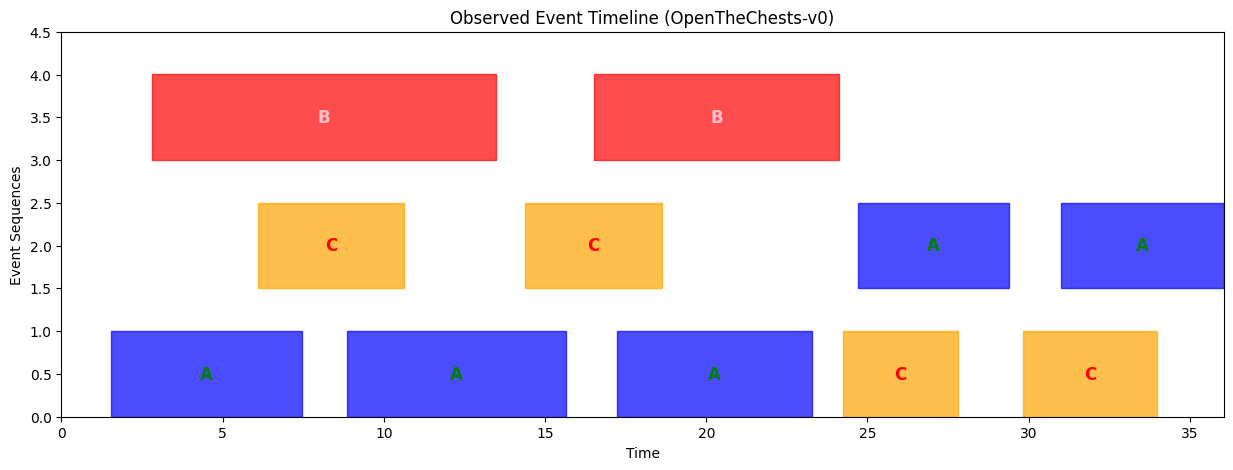

In [5]:
from agent1_patterns_chests_to_reach.utils.data_collectors import collect_observations
from agent1_patterns_chests_to_reach.env.register_envs import register_custom_envs
from agent1_patterns_chests_to_reach.utils.event_encoding import event_to_dict_from_gym
from agent1_patterns_chests_to_reach.utils.visualization import plot_event_timeline

import gym

# Register environments
register_custom_envs()

# Collect and visualize events
observed_events_easy = collect_observations("OpenTheChests-v0", num_steps=10)
plot_event_timeline(observed_events_easy, start_time=0, end_time=observed_events_easy[-1]["end_time"], env_name="OpenTheChests-v0")

### 1.2. Model Training



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
print("✅ CUDA is available:", torch.cuda.is_available())
print("Running on:", torch.cuda.get_device_name(0))


#### 1.2.1. PPO

##### 🧠 What is PPO? (Proximal Policy Optimization)

**Proximal Policy Optimization (PPO)** is a powerful and widely used reinforcement learning algorithm developed by OpenAI.  
It belongs to the family of **actor-critic** and **on-policy** methods, and is used to train agents to learn optimal behavior through interaction with an environment.

PPO uses a **neural network** (often a Multi-Layer Perceptron) to:
- **Predict actions** (actor / policy)
- **Estimate state values** (critic / value function)


---

🧭 Actor-Critic Architecture

PPO uses two main components:

- 🎯 **Actor**: the part of the model that selects an action based on the current state  
  → Learns the *policy* π(a|s)

- 📉 **Critic**: the part that estimates how good a state is (the value function)  
  → Learns the *value* V(s)

Training alternates between improving the **actor** using feedback from the **critic**.

---

🔄 On-Policy vs Off-Policy

PPO is an **on-policy** algorithm:
- It learns only from the most **recent interactions** with the environment
- It **discards old experiences** (unlike DQN or SAC)

This makes it more stable but also more sample-inefficient than off-policy methods.

---

⚙️ How does PPO work?

PPO improves the policy by minimizing a clipped surrogate objective function:

- It avoids taking too large policy updates (which could destabilize training)
- The "Proximal" part ensures updates stay within a trust region

💡 This makes PPO more stable and easier to tune than vanilla Policy Gradient or TRPO.

---

### ✅ Summary

| Property            | Value                          |
|---------------------|---------------------------------|
| Type                | Policy Gradient (Actor-Critic) |
| Architecture        | Deep Learning (MLP, CNN, etc.) |
| Training Style      | On-policy                      |
| Stability           | ✅ Very stable                  |
| Efficiency          | ❗ Less sample-efficient than off-policy methods |
| Usage               | Widely used baseline (e.g. SB3 PPO)

---

📚 PPO is one of the most robust and versatile RL algorithms, and a great starting point for many environments


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
import torch
print("✅ CUDA is available:", torch.cuda.is_available())
print("Running on:", torch.cuda.get_device_name(0))


✅ CUDA is available: True
Running on: Tesla T4


In [14]:
# === 1.2.1. PPO — Model Training ===

import os
import yaml
from agent1_patterns_chests_to_reach.approach1_simple_event_mapping.agents.ppo_agent import train_ppo

# 1. Load PPO config from YAML
PROJECT_ROOT = "/content/robot_task_recognition_rl"
config_path = os.path.join(PROJECT_ROOT, "agent1_patterns_chests_to_reach/config/agent1_ppo_simple.yaml")
with open(config_path, "r") as f:
    cfg = yaml.safe_load(f)

# 2. Redirect save/log paths to Google Drive
base_drive_path = "/content/drive/MyDrive/RL_Agent1"
cfg["save_path"] = os.path.join(base_drive_path, "models/agent1_simple_ppo.zip")
cfg["log_path"] = os.path.join(base_drive_path, "logs/ppo/")

# 4. Ensure folders exist
os.makedirs(os.path.dirname(cfg["save_path"]), exist_ok=True)
os.makedirs(cfg["log_path"], exist_ok=True)

cfg["policy"] = "MultiInputPolicy"

# 5. Train the PPO model
model = train_ppo(
    env_id=cfg["env_id"],
    total_timesteps=cfg["total_timesteps"],
    save_path=cfg["save_path"],
    log_path=cfg["log_path"],
    learning_rate=cfg["learning_rate"],
    policy=cfg["policy"]
)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to /content/drive/MyDrive/RL_Agent1/logs/ppo/PPO_1


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/usr

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.82     |
|    ep_rew_mean     | -6.94    |
| time/              |          |
|    fps             | 573      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 5.89         |
|    ep_rew_mean          | -5.28        |
| time/                   |              |
|    fps                  | 429          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.021444054  |
|    clip_fraction        | 0.327        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.06        |
|    explained_variance   | -0.009824395 |
|    learning_r

#### 1.2.2. DQN



### 1.3. Learning Curves



#### 1.3.1. PPO



In [15]:
# === 1.3.1. PPO — Learning Curves ===

from agent1_patterns_chests_to_reach.utils.plot_learning_curves import plot_learning_curve

# Path to the PPO log directory in Google Drive
ppo_log_path = "/content/drive/MyDrive/RL_Agent1/logs/ppo"

# Plot the learning curve
plot_learning_curve(
    log_dir=ppo_log_path,
    title="PPO - Learning Curve (OpenTheChests-v0)",
    ma_window=5  # Moving average window size
)


FileNotFoundError: monitor.csv not found in /content/drive/MyDrive/RL_Agent1/logs/ppo

#### 1.3.2. DQN



### 1.4. Model Evaluation



#### 1.4.1. PPO



#### 1.4.2. DQN

## 2. Intermediate Approach: Temporal Window

### 2.1. Event Visualization

## 3. Advanced Approach: Sequence Modeling (LSTM / Transformer)

### 3.1. Event Visualization